# What are the most demanded skills for the top 3 most popular data roles?

### Methology

1. Clean-up skill column
2. Calculate skill count based on `job_title_short`
3. Caclulate skill percentage
4. Plot final findings

In [1]:
# Import Libraries
import ast
import pandas as pd
from datasets import load_dataset
import matplotlib.pyplot as plt
import seaborn as sns

# Load Data
dataset = load_dataset('lukebarousse/data_jobs')
df=dataset['train'].to_pandas()

# Data Cleanup
df['job_posted_date'] = pd.to_datetime(df['job_posted_date'])
df['job_skills'] = df['job_skills'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else x)

c:\Users\Mei\anaconda3\envs\clean_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# filter out AUS jobs only
df_aus = df[
    df['job_country'] == 'Australia'
]


# explode job_skills
df_skills = df_aus.explode('job_skills')

df_skills_count = df_skills.groupby(['job_skills', 'job_title_short']).size()


# transform df_skills_count to a DataFrame for easy manipulation
df_skills_count = df_skills_count.reset_index(name='skill_count')

# sort values from large to small
df_skills_count.sort_values(by='skill_count', ascending=False, inplace=True)


In [3]:
# find unique values in job titles and turn it into a list
job_titles = df_skills_count['job_title_short'].unique().tolist()


# get top 3 results from the list
job_titles = sorted(job_titles[:3])

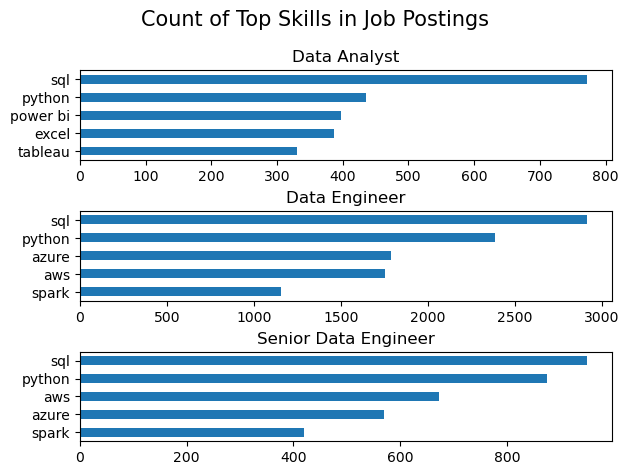

In [4]:
# plotting 3 rows 1 column

fig, ax = plt.subplots(len(job_titles), 1)



for i, job_title in enumerate(job_titles):

    # find jobs that are on the job_titles list
    df_plot = df_skills_count[df_skills_count['job_title_short'] == job_title].head(5)

    # plot a barh chart, x as job skills, y as skill count
    df_plot.plot(
        kind='barh',
        x='job_skills',
        y='skill_count',
        ax=ax[i],
        title=job_title
    )
    ax[i].invert_yaxis()
    ax[i].set_ylabel('')
    ax[i].legend().set_visible(False)

fig.suptitle('Count of Top Skills in Job Postings', fontsize=15)
fig.tight_layout(h_pad=0.5) # fix overlap
plt.show()

#### Convert skill counts to %

In [5]:
# % of skill in a job posting = (skill count in job postings) / (total count of job postings)

# get total job counts and convert to a DataFrame
df_job_title_count= df_aus ['job_title_short'].value_counts().reset_index(name='job_total')

# merge with df_skills_count
df_skills_percent = pd.merge(
    df_skills_count,
    df_job_title_count,
    how='left',
    on='job_title_short'
)

# insert the new column skill percent into the DataFrame and convert it into percentage in numbers

df_skills_percent['skill_percent'] = 100 * df_skills_percent['skill_count'] / df_skills_percent['job_total']

df_skills_percent['skill_percent']

0       62.559038
1       51.266638
2       38.407042
3       37.612709
4       24.838987
          ...    
1302     0.331126
1303     0.107759
1304     0.084818
1305     0.062933
1306     0.331126
Name: skill_percent, Length: 1307, dtype: float64

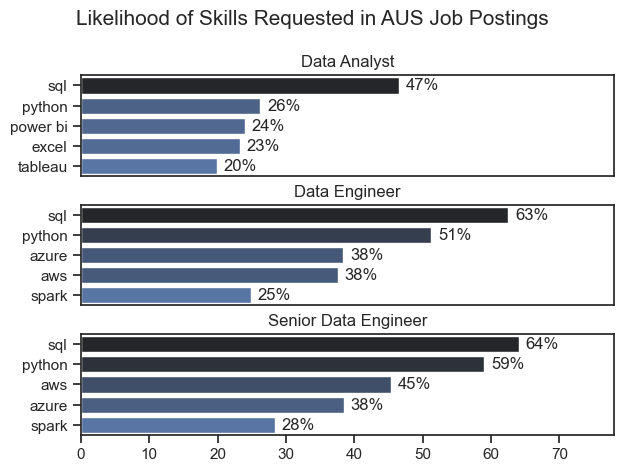

In [7]:
# plotting 3 rows 1 column

fig, ax = plt.subplots(len(job_titles), 1)

sns.set_theme(style='ticks')

for i, job_title in enumerate(job_titles):

    # find jobs that are on the job_titles list
    df_plot = df_skills_percent[df_skills_percent['job_title_short'] == job_title].head(5)

    # plot chart using seaborn
    sns.barplot(
        data=df_plot,
        x='skill_percent',
        y='job_skills',
        ax=ax[i],
        hue='skill_count',
        palette='dark:b_r'
    )
    ax[i].set_title(job_title)
    ax[i].set_xlabel('')
    ax[i].set_ylabel('')
    ax[i].get_legend().remove()
    ax[i].set_xlim(0,78)

    # add labels to each bar by looping through df_plot
    for index, value in enumerate(df_plot['skill_percent']):
        ax[i].text(value +1 , index, f'{value:.0f}%', va='center') 
        # value +1 so its a bit far away from the bar
        # va='center' to position labels in the center
        # f'{value:.0f}%' converts the numbers to a float with no decimal places
    # remove xaxis and only keeping the bottom one
    if i != len(job_titles) -1:
        ax[i].set_xticks([])

        
fig.suptitle('Likelihood of Skills Requested in AUS Job Postings', fontsize=15)
fig.tight_layout(h_pad=0.5) # fix overlap
plt.show()